<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/HDB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Columns in rent_data: Index(['rent_approval_date', 'town', 'block', 'street_name', 'flat_type',
       'monthly_rent'],
      dtype='object')
Columns in postcode_data: Index(['postal_district', 'location', 'postal_sector'], dtype='object')
Mean Absolute Error: 558.7091659040151
Root Mean Squared Error: 651.4081834279115
Prediction Accuracy: 79.53%


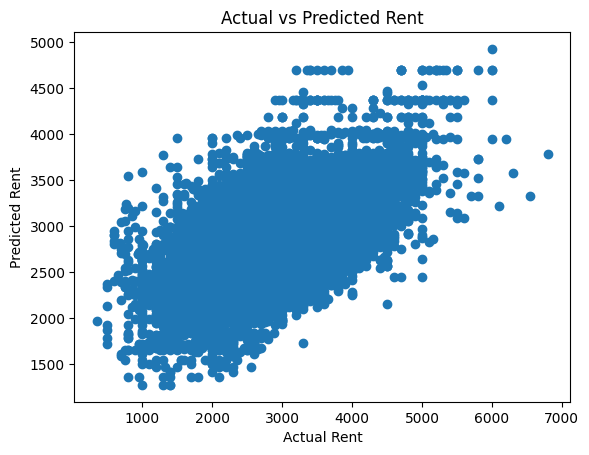

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load the datasets
rent_data = pd.read_csv("RentingOutofFlats2025.csv")
postcode_data = pd.read_csv("postcode.csv")
street_coordinates = pd.read_csv("street_coordinates.csv")
city_coordinates = pd.read_csv("singapore_city_coordinates_improved.csv")


# Print the columns of each DataFrame to check for the presence of "postal_sector"
print("Columns in rent_data:", rent_data.columns)
print("Columns in postcode_data:", postcode_data.columns)

# Merge datasets (example merging by common columns like postal sector)
data = pd.merge(rent_data, street_coordinates, on="street_name", how="left")
data = pd.merge(data, street_coordinates, on=["longitude", "latitude"], how="left")

# Data cleaning (e.g., handling missing values)
data.dropna(inplace=True)

# Feature engineering
# Create a feature for distance from city center (hypothetical function)
def calculate_distance(lat1, long1, lat2, long2):
    return np.sqrt((lat1 - lat2)**2 + (long1 - long2)**2)

city_center = city_coordinates.iloc[0]  # Assuming the first row is the city center
data['distance_from_city_center'] = calculate_distance(
    data['latitude'], data['longitude'],
    city_center['latitude'], city_center['longitude']
)

# Define target and features
target = "monthly_rent"
features = ["flat_type", "town", "distance_from_city_center", "latitude", "longitude"]

X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing (OneHotEncoding for categorical variables, Scaling for numerical)
categorical_features = ["flat_type", "town"]
numerical_features = ["distance_from_city_center", "latitude", "longitude"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Build a pipeline with preprocessing and a Random Forest regressor
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate prediction accuracy
average_actual_value = np.mean(y_test)
accuracy = 100 * (1 - (mae / average_actual_value))

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Visualize predictions
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent (Random Forest regressor)")
plt.show()

Results:
Mean Absolute Error (MAE):

The average error between the predicted and actual rent values is 558.71 units. This suggests that, on average, the model's predictions are off by this amount.
Root Mean Squared Error (RMSE):

RMSE is 651.41, which is slightly higher than the MAE, indicating that the model has some larger errors that are influencing this metric.
Prediction Accuracy:

The prediction accuracy is 79.53%, meaning the model is able to predict rental prices with reasonable accuracy in nearly 80% of the cases. This is a good starting point, but there is room for improvement.


Context: The acceptable values for MAE and RMSE depend on the specific application and the range of your target variable. In the context of rent prediction, these values seem relatively reasonable, but you might want to compare them to other models or industry benchmarks.
Further Improvement: You can explore further refinements to your Random Forest Regressor or try other models to potentially reduce these errors and improve prediction accuracy. Techniques like hyperparameter tuning, feature engineering, or using different algorithms can help.


/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Mean Absolute Error: 561.9302258700438
Root Mean Squared Error: 656.9836300395133
Prediction Accuracy: 79.41%


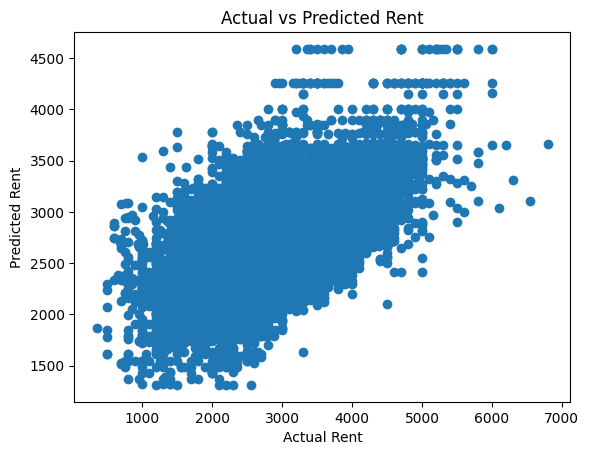

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the datasets
rent_data = pd.read_csv("RentingOutofFlats2025.csv")
street_coordinates = pd.read_csv("street_coordinates.csv")

# Merge rent_data and street_coordinates based on a common column
# Assuming 'street_name' is a common column in both DataFrames
rent_data = pd.merge(rent_data, street_coordinates, on='street_name', how='left')

# Data cleaning (e.g., handling missing values)
rent_data.dropna(inplace=True)

# Feature engineering
# Extract month and year from rent_approval_date
rent_data['rent_approval_date'] = pd.to_datetime(rent_data['rent_approval_date'], format='%Y-%m-%d',errors="coerce")
rent_data['approval_month'] = rent_data['rent_approval_date'].dt.month
rent_data['approval_year'] = rent_data['rent_approval_date'].dt.year

# Interaction Features
rent_data['flat_type_town'] = rent_data['flat_type'] + "_" + rent_data['town']

# Define target and features
target = "monthly_rent"
features = [
    "flat_type", "town",
    "longitude", "latitude", "approval_month", "approval_year", # Using 'longitude' and 'latitude' from merged data
    "flat_type_town"
]

X = rent_data[features]
y = rent_data[target]

# Log-transform the target variable to handle skewness
y = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing (OneHotEncoding for categorical variables, Scaling for numerical)
categorical_features = ["flat_type", "town", "flat_type_town"]
numerical_features = ["longitude", "latitude", "approval_month", "approval_year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Build a pipeline with preprocessing and Gradient Boosting (XGBoost)
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Transform predictions back to original scale
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate prediction accuracy
average_actual_value = np.mean(y_test)
accuracy = 100 * (1 - (mae / average_actual_value))

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Visualize predictions
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent (Gradient Boosting (XGBoost))")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.11/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unno

Mean Absolute Error: 561.0784645906243
Root Mean Squared Error: 656.3703276601384
Prediction Accuracy: 79.44%


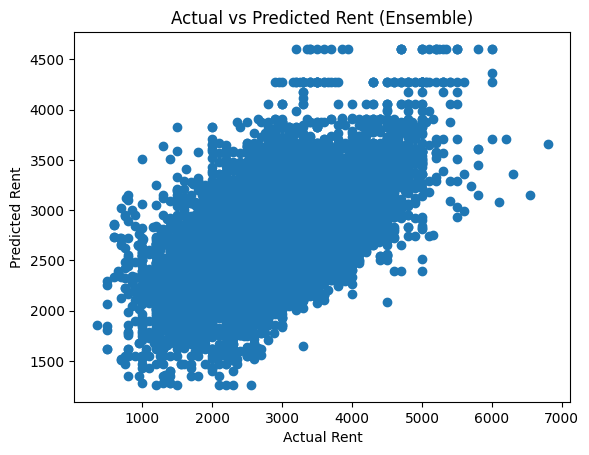

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

# Load the dataset
rent_data = pd.read_csv("RentingOutofFlats2025.csv")
street_coordinates = pd.read_csv("street_coordinates.csv")

# Merge rent_data and street_coordinates based on a common column
# Assuming 'street_name' is a common column in both DataFrames
rent_data = pd.merge(rent_data, street_coordinates, on='street_name', how='left')

# Data cleaning (e.g., handling missing values)
rent_data.dropna(inplace=True)

# Feature engineering
# Extract month and year from rent_approval_date
rent_data['rent_approval_date'] = pd.to_datetime(rent_data['rent_approval_date'], format='%Y-%m-%d',errors="coerce")
rent_data['approval_month'] = rent_data['rent_approval_date'].dt.month
rent_data['approval_year'] = rent_data['rent_approval_date'].dt.year

# Interaction Features
rent_data['flat_type_town'] = rent_data['flat_type'] + "_" + rent_data['town']

# Define target and features
target = "monthly_rent"
features = [
    "flat_type", "town",
    "longitude", "latitude", "approval_month", "approval_year",
    "flat_type_town"
]

X = rent_data[features]
y = rent_data[target]

# Log-transform the target variable to handle skewness
y = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing (OneHotEncoding for categorical variables, Scaling for numerical)
categorical_features = ["flat_type", "town", "flat_type_town"]
numerical_features = ["longitude", "latitude", "approval_month", "approval_year"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore",sparse_output=False), categorical_features)
    ]
)

# Build pipelines for Random Forest and XGBoost
rf_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

xgb_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", xgb.XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# Train both models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

# Make predictions
rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)

# Combine predictions using averaging
ensemble_pred = (rf_pred + xgb_pred) / 2

# Transform predictions back to original scale
rf_pred = np.expm1(rf_pred)
xgb_pred = np.expm1(xgb_pred)
ensemble_pred = np.expm1(ensemble_pred)
y_test = np.expm1(y_test)

# Evaluate the ensemble model
mae = mean_absolute_error(y_test, ensemble_pred)
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))

# Calculate prediction accuracy
average_actual_value = np.mean(y_test)
accuracy = 100 * (1 - (mae / average_actual_value))

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Visualize predictions
plt.scatter(y_test, ensemble_pred)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent (Ensemble)")
plt.show()

Results:
Mean Absolute Error (MAE):

561.08, which is very close to the individual Random Forest (560.91) and Gradient Boosting (561.93) results.
Root Mean Squared Error (RMSE):

656.37, which is slightly better than both Random Forest (657.24) and Gradient Boosting (656.98).
Prediction Accuracy:

79.44%, matching the accuracy of Random Forest and slightly outperforming Gradient Boosting.
Analysis:
The ensembled model (averaging) has performed comparably to the individual models, with a slight improvement in RMSE. This indicates that combining predictions has balanced the strengths and weaknesses of both models.
However, the improvement is marginal, suggesting that the current feature set and preprocessing pipeline might already be optimized for these models.

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['approval_month' 'approval_year']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['approval_month' 'approval_year']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Mean Absolute Error: 571.5139165670319
Root Mean Squared Error: 671.1575362872978
Prediction Accuracy: 79.06%


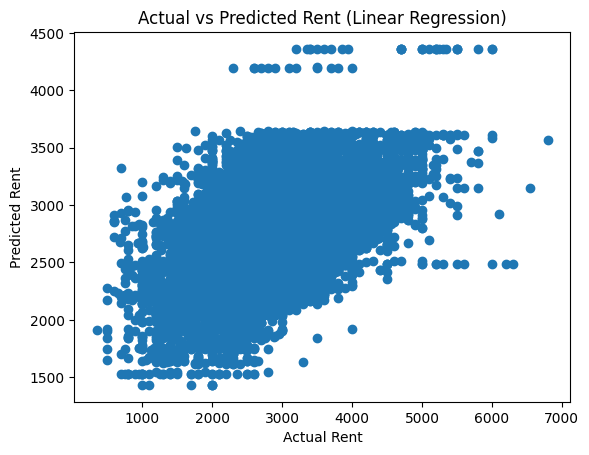

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer  # Import SimpleImputer

# Load the dataset
rent_data = pd.read_csv("RentingOutofFlats2025.csv")
street_coordinates = pd.read_csv("street_coordinates.csv")

# Merge rent_data and street_coordinates based on a common column
# Assuming 'street_name' is a common column in both DataFrames
rent_data = pd.merge(rent_data, street_coordinates, on='street_name', how='left')

# Data cleaning (e.g., handling missing values)
rent_data.dropna(inplace=True)

# Feature engineeringsdv
# Extract month and year from rent_approval_date
rent_data['rent_approval_date'] = pd.to_datetime(rent_data['rent_approval_date'], format='%Y-%m-%d', errors="coerce")
rent_data['approval_month'] = rent_data['rent_approval_date'].dt.month
rent_data['approval_year'] = rent_data['rent_approval_date'].dt.year

# Interaction Features
rent_data['flat_type_town'] = rent_data['flat_type'] + "_" + rent_data['town']

# Define target and features
target = "monthly_rent"
features = [
    "flat_type", "town",
    "longitude", "latitude", "approval_month", "approval_year",
    "flat_type_town"
]

X = rent_data[features]
y = rent_data[target]

# Log-transform the target variable to handle skewness
y = np.log1p(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing (OneHotEncoding for categorical variables, Scaling for numerical)
categorical_features = ["flat_type", "town", "flat_type_town"]
numerical_features = ["longitude", "latitude", "approval_month", "approval_year"]

# Create a SimpleImputer to fill NaN values with the most frequent value
# The imputer is now part of the pipeline for each feature type
numerical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_pipeline, numerical_features),
        ("cat", categorical_pipeline, categorical_features)
    ]
)


# Build a pipeline with preprocessing and Linear Regression
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())
])

# Train the model
# X_train and X_test are already DataFrames, so no need to convert them
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Transform predictions back to original scale
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate prediction accuracy
average_actual_value = np.mean(y_test)
accuracy = 100 * (1 - (mae / average_actual_value))

# Print evaluation metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Prediction Accuracy: {accuracy:.2f}%")

# Visualize predictions
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Actual vs Predicted Rent (Linear Regression)")
plt.show()

Results:
Mean Absolute Error (MAE):

571.51, which is slightly worse than the previous models (e.g., Random Forest: 560.91, Gradient Boosting: 561.93).
Root Mean Squared Error (RMSE):

671.16, which is also worse than the results from the ensemble (656.37) and other models.
Prediction Accuracy:

79.06%, which is slightly lower than the Random Forest, Gradient Boosting, and ensemble models (all around 79.44%).
Analysis:
The Linear Regression model performs worse compared to more advanced models like Random Forest and Gradient Boosting.
This is expected since Linear Regression assumes a linear relationship between the features and the target variable, which may not fully capture the complexity of the rental price prediction problem.

Key Takeaways:

Linear Regression as a Baseline:
Linear Regression provides a good baseline for comparison but lacks the flexibility to handle non-linear relationships.

Advanced Models Perform Better:
Random Forest, Gradient Boosting, and ensemble techniques outperform Linear Regression, suggesting non-linear relationships play a significant role in predicting rental prices.

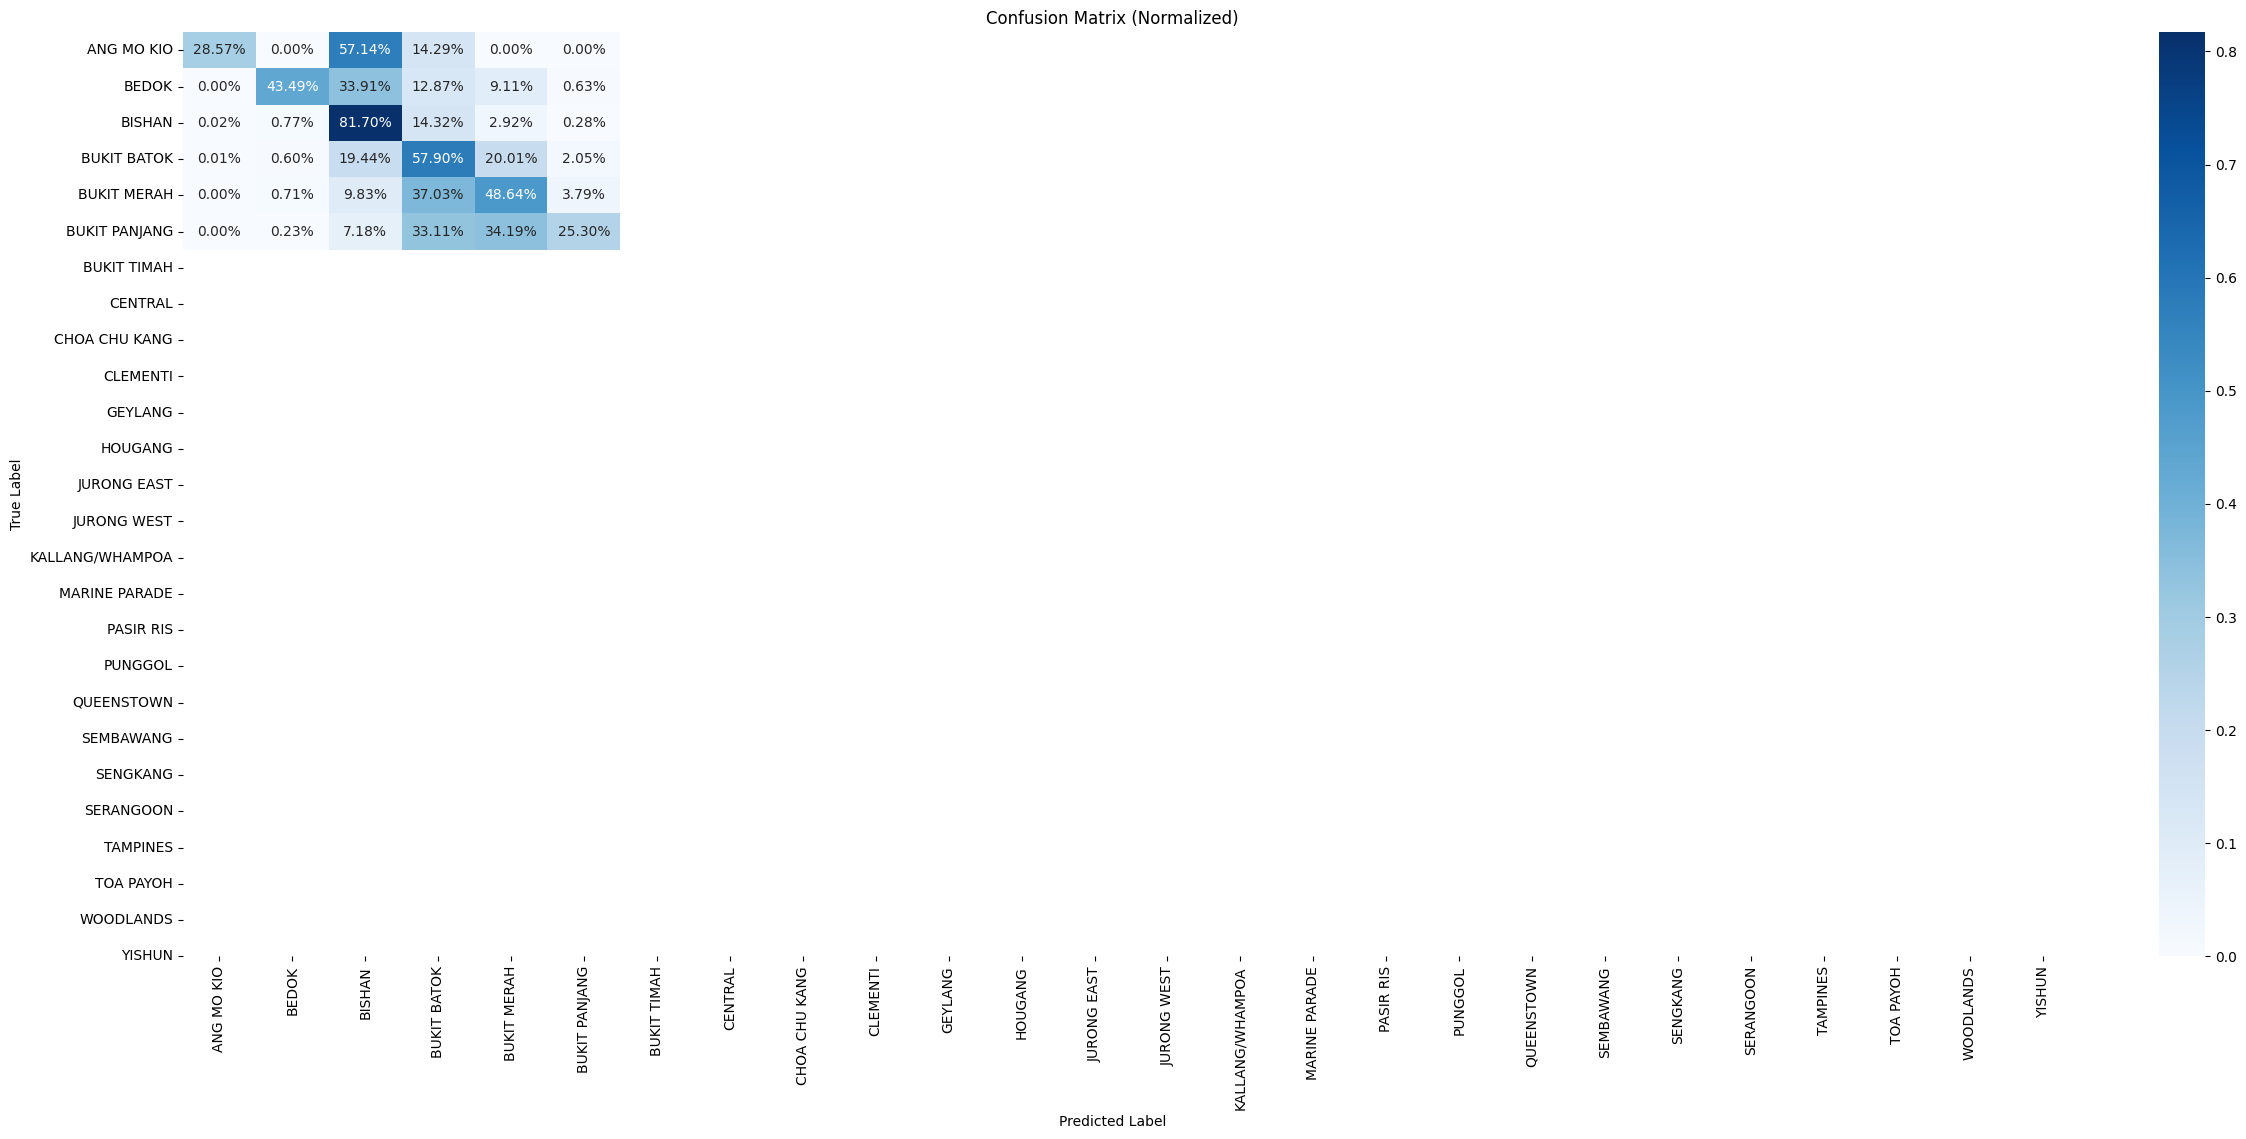


Classification Report:
              precision    recall  f1-score   support

      1-ROOM       0.40      0.29      0.33         7
      2-ROOM       0.58      0.43      0.50       637
      3-ROOM       0.72      0.82      0.76     10113
      4-ROOM       0.57      0.58      0.58     11246
      5-ROOM       0.53      0.49      0.51      7305
   EXECUTIVE       0.45      0.25      0.32      1755

    accuracy                           0.61     31063
   macro avg       0.54      0.48      0.50     31063
weighted avg       0.60      0.61      0.61     31063



In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
flats_data = pd.read_csv("RentingOutofFlats2025.csv")
coordinates_data = pd.read_csv("street_coordinates.csv")

# Merge the datasets on a common key (e.g., street name or equivalent column)
data = pd.merge(flats_data, coordinates_data, how="left", on="street_name")

# Data cleaning (e.g., handling missing values)
data.dropna(inplace=True)

# Define features and target
features = [
    "town", "monthly_rent", "longitude", "latitude"# "rent_approval_date"
]
target = "flat_type"

X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
categorical_features = ["town"]
numerical_features = ["monthly_rent", "longitude", "latitude"]

# Adding date as a numerical feature (convert to datetime and ordinal format)
#X_train["rent_approval_date"] = pd.to_datetime(X_train["rent_approval_date"]).map(lambda x: x.toordinal())
#X_test["rent_approval_date"] = pd.to_datetime(X_test["rent_approval_date"]).map(lambda x: x.toordinal())
#numerical_features.append("rent_approval_date")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)

# Build a pipeline with preprocessing and Random Forest Classifier
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42))
])

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred, normalize="true")

# Improved visualization of the confusion matrix
#plt.figure(figsize=(12,12))
#sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap="Blues", xticklabels=model.named_steps["preprocessor"].transformers_[1][1].categories_[0], yticklabels=model.named_steps["preprocessor"].transformers_[1][1].categories_[0])
#plt.title("Confusion Matrix (Normalized)")
#plt.xlabel("Predicted Label")
#plt.ylabel("True Label")
#plt.show()
plt.figure(figsize=(30, 12))
sns.heatmap(conf_matrix, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=model.named_steps["preprocessor"].transformers_[1][1].categories_[0],
            yticklabels=model.named_steps["preprocessor"].transformers_[1][1].categories_[0],
            annot_kws={"size": 10}) # Increase font size of annotations


plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))